In [75]:
import pymongo as pm
import gridfs
import cPickle
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pylab

import tensorflow as tf
from scipy import misc
import os
import time

import jupyter_utils as utils

In [77]:
reload(utils)
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
jpgs = utils.image_utils.load_img_strings_from_tfrecord(
    '/mnt/fs1/azhai/image_label_widx_first100/validation-00101-of-00128', limit=50)

# temporary hack to simulate some of the data augmentation steps
from resnet_th_preprocessing import ApplyGray, ColorJitter
def evaluate_tf(img, op, *args):
    g = tf.Graph()
    with g.as_default():
        res = op(img, *args)
    sess = tf.Session(graph=g, config=tf.ConfigProto(device_count={'GPU':0}))
    res = sess.run(res)
    sess.close()
    return res

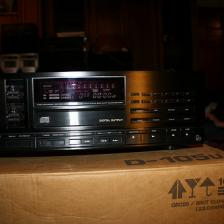

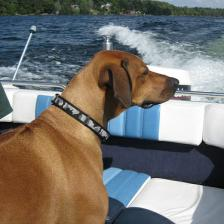

In [81]:
def get_croppings(img_str):
    img = utils.image_utils.ImageData(img_str)
    # print('shape', img.shape)
    utils.display_img_array(img.crop_to_center())

    h, w, _ = img.shape
    bboxs = utils.image_utils.get_cropping_grid(w, h, crop_size=int(0.8*min(w, h)), grid_size=2)
    croppings = []
    for bbox in bboxs:
        # print 'bbox', bbox
        img_tensor = img.as_cropped_tensor(bbox[0], bbox[1], scaled=True)
        croppings.append(img_tensor)
    # utils.display_img_array(img.as_tensor())
    # for c in croppings:
    #     utils.display_img_array(c)
    return croppings
        
c1 = get_croppings(jpgs[43])
c2 = get_croppings(jpgs[44])

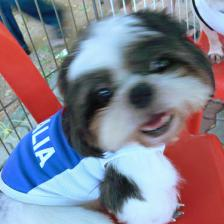

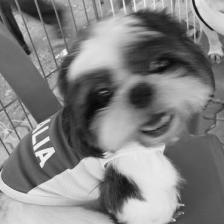

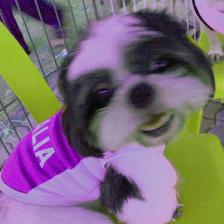

In [82]:
# prepare a set of inputs

one_img = utils.image_utils.ImageData(jpgs[28]).crop_to_center()

rotc1 = [np.rot90(x) for x in c1]
rotc2 = [np.rot90(x) for x in c2]
#img_inputs = np.concatenate((c1, c2))
#img_inputs = np.concatenate((c1, rotc1, c2, rotc2))
img_inputs = [one_img, evaluate_tf(one_img, ApplyGray, 1.0), evaluate_tf(one_img, ColorJitter)] 
for img in img_inputs:
    utils.display_img_array(img)

Could not find record at step 1000000, using step 990891 instead.
Using already present file at extraction path /mnt/fs1/azhai/checkpoints/instance_task/control/checkpoint-990891.
Restoring model from /mnt/fs1/azhai/checkpoints/instance_task/control/checkpoint-990891
INFO:tensorflow:Restoring parameters from /mnt/fs1/azhai/checkpoints/instance_task/control/checkpoint-990891


INFO:tensorflow:Restoring parameters from /mnt/fs1/azhai/checkpoints/instance_task/control/checkpoint-990891


array([[ 1.   ,  0.955,  0.944],
       [ 0.955,  1.   ,  0.891],
       [ 0.944,  0.891,  1.   ]], dtype=float32)


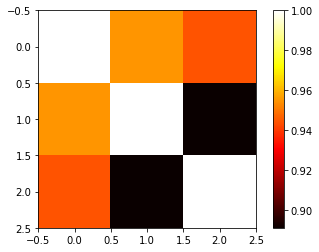

In [84]:

tr = utils.TfutilsReader('instance_task', 'control', 'full', port=27009, cache_dir='/mnt/fs1/azhai/checkpoints')
with tf.Graph().as_default():
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
    model_info = utils.load_model(sess, tr, step_num=1000000)
    input = model_info['input_handle']
    network = model_info['embedding']
    res = sess.run(network, feed_dict={
        input: img_inputs
    })
    dps = np.dot(res, res.T)
    print(np.array_repr(dps, precision=3))
    plt.imshow(dps, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()
    sess.close()